Россманн управляет более чем 3000 аптек в 7 странах Европы. Нам предоставлены исторические данные о продажах 1115 магазинов Rossmann. Задача - спрогнозировать столбец «Продажи» для набора тестов.

In [1]:
# подключим неободимые библиотеки
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter, NullLocator
import seaborn as sns

import calendar
import holidays
from tqdm import tqdm
from collections import Counter


from IPython.display import clear_output
import datetime
import dateutil.relativedelta

%matplotlib inline

In [2]:
## Создадим функцию для загрузки данных в DataFrame
def get_data(train_path=None, test_path=None, store_path=None, sample_path=None, marker='train'):
    
        if marker == 'train':
            df_train = pd.read_csv(train_path)
            return df_train
        elif marker == 'test':
            df_test = pd.read_csv(test_path)
            return df_test
        elif marker == 'store':
            df_store = pd.read_csv(store_path)
            return df_store
        elif marker == 'sample':
            df_sample = pd.read_csv(sample_path)
            return df_sample
        else:
            raise NameError

In [3]:
## Определяем путь до каждого из исходных файлов
train_path = '../input/rossmann-store-sales/train.csv'
test_path = '../input/rossmann-store-sales/test.csv'
store_path = '../input/rossmann-store-sales/store.csv'
sample_path = '../input/rossmann-store-sales/sample_submission.csv'
df_train = get_data(train_path=train_path, marker='train')
df_train.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


## 1. Предобработка данных
 - Групировка данных
 - Фильтрация
 - Построение пробной модели

In [4]:
## Создадим функии для обработки данных

## merge_data - функция, объединяющая два исходных датасета

## preprocessed_data - функция для предобработки данных. Здесь мы приводим дату к нормальному типу,
# создаем признаки месяца и года, заполняем имеющиеся пропуски необхоимыми значениями,
# а также отрезаем часть датасета, в котором содержится информация о днях когда магазн закрыт

## split_data - функция для разбиения данных на обучение и тест. В тест берем данные за последние
# два месяца из обучающей выборки

## encode_data, drop - функции для кодирования и удаления определенных столбцов наших данных соответственно

## test_filter - отдельная функция для разделения тестовых данных по принципу закрыт магазин или нет


def merge_data(df_train, df_store):
    df1 = df_train.copy()
    df2 = df_store.copy()
    return pd.merge(df1, df2, on='Store', how='left')  
        

def preprocessed_data(dataframe, marker='train'):
    df = dataframe.copy()
    
    df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
    df['month'] = df.Date.apply(lambda x: x.month)
    df['year'] = df.Date.apply(lambda x: x.year)
    
    df[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']] = df[['CompetitionOpenSinceMonth', 
                                                                        'CompetitionOpenSinceYear']].fillna(0)
    df[['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = df[['Promo2SinceWeek', 'Promo2SinceYear', 
                                                                      'PromoInterval']].fillna(0)
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(max(df['CompetitionDistance']))
    df.StateHoliday = df.StateHoliday.apply(lambda x: str(x))
    
    if marker == 'train':
        df = df[df.Open == 1]
        df = df[df.Sales > 0]
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    number = 0
    last_month=df.month.values[0]
    def create_month_number(current_month):
        nonlocal number
        nonlocal last_month
        if last_month != current_month:
            number +=1
            last_month = current_month
            return number
        else: 
            return number
    
    df['month_number'] = df.month.apply(lambda x: create_month_number(x))
    return df



def split_data(df_train, marker='val', random_state=42):
    
    df = df_train.copy()
    last_2_month = sorted(df.month_number.unique())[-2]
    if marker == 'val':
        df_train = df[df.month_number < last_2_month]
        df_test = df[df.month_number >= last_2_month]
        X_train = df_train.drop(columns='Sales')
        y_train = df_train['Sales']
        X_test = df_test.drop(columns='Sales')
        y_test = df_test['Sales']
        return X_train, X_test, y_train, y_test
    else:
        X = df.drop(columns='Sales')
        y = df['Sales']
        return X, y
        
        

def encode_data(X_train, X_test=None, cat_columns=[]):
    train = X_train.copy()
    if X_test is not None:
        test = X_test.copy()
    encoder = LabelEncoder()
    for column in cat_columns:
        train[column] = encoder.fit_transform(train[column])
        try:
            test[column] = encoder.fit_transform(test[column])
        except:
            print('X_test not identify')
    return train, test



def drop(dataframe, drop_columns=[]):
    df = dataframe.copy()
    df = df.drop(columns=drop_columns)
    return df


def test_filter(dataframe):
    df = dataframe.copy()
    df.Open = df.Open.fillna(1)
    df_closed = df[df.Open == 0].sort_values(by="Id").reset_index(drop=True)
    df_open = df[df.Open == 1]
    df_closed['Sales'] = np.zeros(df_closed.shape[0])
    return df_closed, df_open

In [5]:
## Создаем функции для обучения и подсчета метрик

## calculate_metrics - функция считает все мнеобходимые метрики для обучения и теста(если возможно).
# Мы будем считать метрики R2, MAE, RMSE, а также целевую метрику для данно задачи RMSPE
## rmspe, rmspe_boost - рассчет самой метрики RMSPE и дополнение для использования данной метрики
# при валлидации LGBM

## train_boosting - функция для обучения модели одного из трех бустингов: LightGB, XGB, CatBosst
## predict_boosting - соответсвующая функция для предсказания результата и вывода рассчитаных метрик


def calculate_metrics(marker, pred_train, pred_test, true_train, true_test=None):
    
    r2_train = r2_score(true_train, pred_train)
    mae_train = mae(true_train, pred_train)
    rmse_train = np.sqrt(mse(true_train, pred_train))
    rmspe_train = rmspe(true_train, pred_train)
    
    if marker == 'val':
        r2_test = r2_score(true_test, pred_test)
        mae_test = mae(true_test, pred_test)
        rmse_test = np.sqrt(mse(true_test, pred_test))
        rmspe_test = rmspe(true_test, pred_test)
        return r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test, rmspe_train, rmspe_test
    
    else: 
        return r2_train, mae_train, rmse_train, rmspe_train


def rmspe(y_true, y_pred):
     return np.sqrt(np.mean(((y_true-y_pred)/y_true)**2))

def rmspe_boost(preds, train_data):

    labels = train_data.get_label()

    return 'rmspe', rmspe(labels, preds), True
  


def train_boosting(boost, params, X_train, y_train, X_test=None, y_test=None, marker='val',
                   num_rounds=1000, early_stoping=100, verbose=20, feval=None, boost_type='lgb'):
    
    if boost_type == 'lgb':
        
        train_data = boost.Dataset(data=X_train, label=y_train)
        if marker == 'val':
            validate_data = boost.Dataset(data=X_test, label=y_test)
            return boost.train(params, train_data, num_rounds, valid_sets=[validate_data],
                               early_stopping_rounds=early_stoping, verbose_eval=verbose, feval=feval)
                        
        else:
            return boost.train(params, train_data, num_rounds, feval=feval)
        
    elif boost_type == 'xgb':
        dtrain = xgb.DMatrix(X_train, y_train)
        if marker == 'val':
            dvalid = xgb.DMatrix(X_test, y_test)
            watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
            return xgb.train(params, dtrain, num_boost_round=num_rounds, evals=watchlist, \
                             early_stopping_rounds=early_stoping, verbose_eval=True)
        else:
            watchlist = [(dtrain, 'train')]
            return xgb.train(params, dtrain, num_boost_round=num_rounds, evals=watchlist)
    
    elif boost_type == 'ctb':
        train_pool = ctb.Pool(data=X_train, label = y_train)
        model = CatBoostRegressor(**params)
        if marker == 'val':
            val_pool = ctb.Pool(data=X_test, label=y_test)
            model.fit(train_pool, eval_set=val_pool, verbose=verbose, use_best_model=True)
            return model
        else:
            val_pool = ctb.Pool(data=X_train[-48000:], label=y_train[-48000:])
            model.fit(train_pool, eval_set=val_pool, verbose=verbose, use_best_model=True)
            return model



def predict_boosting(boost, X_train, X_test, y_train, y_test=None, boost_type='lgb'):
    
    if boost_type == 'lgb':
        y_pred_train = boost.predict(X_train)
        y_pred_test = boost.predict(X_test)
    elif boost_type == 'xgb':
        X_train = xgb.DMatrix(X_train)
        X_test = xgb.DMatrix(X_test)
        y_pred_train = boost.predict(X_train)
        y_pred_test = boost.predict(X_test)
    elif boost_type == 'ctb':
        X_train = ctb.Pool(data=X_train)
        X_test = ctb.Pool(data=X_test)
        y_pred_train = boost.predict(X_train)
        y_pred_test = boost.predict(X_test)
    
    if y_test is not None:
        (r2_train, r2_test, mae_train, mae_test, rmse_train,
        rmse_test, rmspe_train, rmspe_test) = calculate_metrics('val', y_pred_train, y_pred_test,
                                                                y_train, y_test)
                                                                                         
        print('R2 на обучении: {}, R2 на тесте: {}'.format(r2_train, r2_test))
        print('MAE на обучении: {}, MAE на тесте: {}'.format(mae_train, mae_test))
        print('RMSE на обучении: {}, RMSE на тесте: {}'.format(rmse_train, rmse_test))
        print('RMSPE на обучении: {}, RMSPE на тесте: {}'.format(rmspe_train, rmspe_test))
    else:
        r2_train, mae_train, rmse_train, rmspe_train = calculate_metrics('test', y_pred_train,
                                                                         y_pred_test, y_train)
        
        print('R2 на обучении: {}'.format(r2_train))
        print('MAE на обучении: {}'.format(mae_train))
        print('RMSE на обучении: {}'.format(rmse_train))
        print('RMSPE на обучении: {}'.format(rmspe_train))
    
    return y_pred_test


In [7]:
%%time
## Преобразуем наши данные

df_store = get_data(store_path=store_path, marker='store')
df = merge_data(df_train, df_store)
df = preprocessed_data(df)
df.head()

CPU times: user 8.99 s, sys: 664 ms, total: 9.65 s
Wall time: 9.68 s


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,month,year,month_number
0,1097,2,2013-01-01,5961,1405,1,0,a,1,b,...,720.0,3.0,2002.0,0,0.0,0.0,0,1,2013,0
1,85,2,2013-01-01,4220,619,1,0,a,1,b,...,1870.0,10.0,2011.0,0,0.0,0.0,0,1,2013,0
2,259,2,2013-01-01,6851,1444,1,0,a,1,b,...,210.0,0.0,0.0,0,0.0,0.0,0,1,2013,0
3,262,2,2013-01-01,17267,2875,1,0,a,1,b,...,1180.0,5.0,2013.0,0,0.0,0.0,0,1,2013,0
4,274,2,2013-01-01,3102,729,1,0,a,1,b,...,3640.0,0.0,0.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct",1,2013,0


In [8]:
%%time
## Попробууем обучить первую модель - CatBoost

cat_columns = ['StateHoliday', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceYear',
               'StoreType', 'Assortment']
drop_columns = ['Date', 'Customers', 'PromoInterval', 'year', 'Open', 'month_number']
X_train, X_test, y_train, y_test = split_data(df)
X_train, X_test = encode_data(X_train, X_test, cat_columns)
X_train = drop(X_train, drop_columns)
X_test = drop(X_test, drop_columns)

params = {'max_depth': 9, 'iterations': 2000, 'learning_rate': 0.1}

num_rounds = 2000
early_stoping = None
boost_type = 'ctb'
boost = ctb
bst = train_boosting(boost, params, X_train, y_train, X_test=X_test, y_test=y_test,
                     marker='val', num_rounds=num_rounds, early_stoping=early_stoping,
                     verbose=200, feval=rmspe_boost, boost_type=boost_type)
preds = predict_boosting(bst, X_train, X_test, y_train, y_test, boost_type='ctb')

0:	learn: 3015.0718112	test: 3033.8909486	best: 3033.8909486 (0)	total: 167ms	remaining: 5m 34s
200:	learn: 1388.1036469	test: 1425.3109900	best: 1425.3109900 (200)	total: 17.9s	remaining: 2m 39s
400:	learn: 1172.7610240	test: 1226.6991236	best: 1226.6991236 (400)	total: 36s	remaining: 2m 23s
600:	learn: 1094.7134593	test: 1162.9205745	best: 1162.9205745 (600)	total: 53.7s	remaining: 2m 4s
800:	learn: 1054.9682261	test: 1137.4053521	best: 1137.4053521 (800)	total: 1m 11s	remaining: 1m 46s
1000:	learn: 1031.7161607	test: 1126.0342438	best: 1126.0342438 (1000)	total: 1m 28s	remaining: 1m 28s
1200:	learn: 1016.1189649	test: 1119.7701871	best: 1119.7303220 (1198)	total: 1m 46s	remaining: 1m 10s
1400:	learn: 1004.9106494	test: 1116.3829093	best: 1116.3829093 (1400)	total: 2m 3s	remaining: 52.8s
1600:	learn: 995.8595140	test: 1114.3900456	best: 1114.3406010 (1544)	total: 2m 20s	remaining: 35.1s
1800:	learn: 988.9505706	test: 1113.9997422	best: 1113.5379198 (1740)	total: 2m 38s	remaining: 17.

  RMSE на валлидации получилось слишком большим, но RMSPE довльно хорошим, если отталкиваться от результатов других людей.

## 2. Визуализация данных

In [9]:
## Создадим класс для визуализации

class Vizualization:
    """ Класс для визуализации данных """

    def __init__(self, dataframe):
        self.data = dataframe.copy()

    @property
    def plot_time_realations(self):    ## атрибут отображающий динамику продаж во всех магазинах                         
        sns.reset_orig()               # в целом по месяцам, а также для двух случайных магазинов по дням
        df_group_date = self.data.groupby('month_number')['Sales'].sum().reset_index(drop=True)
        store_1 = int(np.random.randint(min(self.data.Store.unique()), max(self.data.Store.unique()), 1))
        store_2 = int(np.random.randint(min(self.data.Store.unique()), max(self.data.Store.unique()), 1))

        fig = plt.figure(figsize=(27,15))
        fig.suptitle('Динамика продаж', fontsize=20)
        gs = GridSpec(ncols=2, nrows=2, figure=fig)

        ax1 = fig.add_subplot(gs[1,:])
        ax1.set_title('Суммарная динамика продаж по месяцам', fontsize=16)
        ax1.plot(df_group_date.values, '--', color='blue', linewidth=3, marker='o',
              markersize=10, markerfacecolor='skyblue', alpha=0.7, label='Sales')
        ax1.set_xlabel('Месяц', fontsize=14, alpha=0.8)
        ax1.set_ylabel('Продажи', fontsize=14, alpha=0.8)
        ax1.legend(loc='best', fontsize=14)
        ax1.grid()

        ax2 = fig.add_subplot(gs[0,0])
        ax2.set_title('Динамика продаж: магазин {}'.format(store_1), fontsize=16)
        ax2.plot(self.data.Sales[self.data.Store == store_1].values, color='green',
              linewidth=0.3,label='Sales')
        ax2.set_xlabel('День', fontsize=14, alpha=0.8)
        ax2.set_ylabel('Продажи', fontsize=14, alpha=0.8)
        ax2.legend(loc='best', fontsize=14)
        ax2.grid()

        ax3 = fig.add_subplot(gs[0,1])
        ax3.set_title('Динамика продаж: магазин {}'.format(store_2), fontsize=16)
        ax3.plot(self.data.Sales[self.data.Store == store_1].values, color='green',
             linewidth=0.3,label='Sales')
        ax3.set_xlabel('День', fontsize=14, alpha=0.8)
        ax3.set_ylabel('Продажи', fontsize=14, alpha=0.8)
        ax3.legend(loc='best', fontsize=14)
        ax3.grid()

        plt.show()
        sns.reset_orig()


    def plot_store_sales_customers(self, sample_size=5000):   ## Изобразим самые популрные 
                                                              ##  магазины(по уровню продаж) числа посетителей 
        sns.reset_orig()                                      ## и посмотрим на зависимость суммы продаж
        idx = np.random.choice(range(self.data.shape[0]), size=sample_size, replace=False)
        
        fig = plt.figure(figsize=(27,15))
        fig.suptitle('Продажи и посетители', fontsize=20)
        gs = GridSpec(ncols=2, nrows=2, figure=fig)

        ax1 = fig.add_subplot(gs[1,:])
        ax1.set_title('Зависимость продаж от количества посетителей', fontsize=16)
        regplot = sns.regplot(data=self.data.iloc[idx], x='Customers', y='Sales', ax=ax1 , 
                              color='green', label='reg_line', line_kws={'linestyle': '--', 'alpha': 0.7, 
                                                                         'linewidth': 3.5}
                              , scatter_kws={'s': 80, 'alpha': 0.25, 'facecolors': 'lightgreen'})
        ax1.set_xlabel('Количество посетителей', fontsize=14, alpha=0.8)
        ax1.set_ylabel('Продажи', fontsize=14, alpha=0.8)
        ax1.legend(loc='best', fontsize=14)
        ax1.grid()



        values = self.data.groupby('Store')['Sales'].sum().values
        labels = self.data.groupby('Store')['Sales'].sum().index
        labels = [labels[i] for i in range(len(labels)) if values[i]/sum(values) > 0.0025]
        values_1 = [values[i] for i in range(len(values)) if values[i]/sum(values) > 0.0025]
        labels_1 = ['Магазин {}'.format(label) for label in labels]
        
        def make_autopct(total_pct):
            def my_autopct(pct):
                pct = total_pct*pct
                return '{p:.2f}%'.format(p=pct)
            return my_autopct
        
        ax2 = fig.add_subplot(gs[0,0])
        ax2.set_title('Доля от общего количества продаж в самых популярных магазинах')
        ax2.pie(values_1, autopct=make_autopct(sum(values_1)/sum(values)), textprops={'fontsize': 13},
                shadow=True, colors=['aquamarine', 'azure', 'gold', 'lightgreen', 'silver'], 
                wedgeprops = {'width': 0.9}, explode=[0,0.1,0,0,0])
        ax2.legend(labels_1, loc='upper left', fontsize=8)


        total_customers = np.sum(self.data.Customers)
        values_2 = self.data[self.data.Store.isin(labels)].groupby('Store')['Customers'].sum().values
        labels_2 = self.data[self.data.Store.isin(labels)].groupby('Store')['Customers'].sum().index
        labels_2 = ['Магазин {}'.format(label) for label in labels_2]

        ax3 = fig.add_subplot(gs[0,1])
        ax3.set_title('Доля от общего количества посетителей в самых популярных магазинах')
        ax3.pie(values_2, autopct=make_autopct(sum(values_2)/total_customers), textprops={'fontsize': 13},
                shadow=True,  colors=['aquamarine', 'azure', 'gold', 'lightgreen', 'silver'], 
                wedgeprops = {'width': 0.9}, explode=[0,0.1,0,0,0])
        ax3.legend(labels_2, loc='upper right', fontsize=8)

        plt.show()
        sns.reset_orig()

     ## Метод отображает зависимость продаж и числа посетителей в зависимсти от 
     # модели магазина и от ассортимента в магазине
    def plot_sales_customers_relations(self, sample_size=5000, feature='StoreType', alpha=0.5): 
        sns.reset_orig()                                                                        
        idx = np.random.choice(range(self.data.shape[0]), size=sample_size, replace=False)
        


        sns.set(font_scale=1.5)
        pairplot = sns.pairplot(data=self.data.iloc[idx], x_vars=['Sales', 'Customers'], y_vars=['Sales', 'Customers'],
                                height=8, aspect=16/8, diag_kind='hist', kind='scatter', diag_kws={'alpha': alpha, 'bins':30}, 
                                plot_kws={'alpha': 0.8, 's': 150, 'linewidth': 2}, hue=feature)
        if feature == 'StoreType':
            pairplot.fig.suptitle('Распределение количества продаж и количества посетителей в зависимости от модели магазина', fontsize=26)
        elif feature == 'Assortment':
            pairplot.fig.suptitle('Распределение количества продаж и количества посетителей в зависимости от ассортимента магазина', fontsize=26)
        sns.reset_orig()


    @property
    def plot_sales_promo_realation(self):   ## Зависимость продаж от наличия промо акций
        
        sns.reset_orig()
        df = self.data.copy()
        df['Promo'] = df['Promo'].apply(lambda x: 'Есть акция' if x==1 else 'Нет акции')
        df_group_store = self.data.groupby('Store').agg({'Sales': 'sum', 'Promo2': 'mean'}).reset_index(drop=True)
        df_group_store['Promo2'] = df_group_store['Promo2'].apply(lambda x: 'Есть акция' if x==1 else 'Нет акции')
        
        fig = plt.figure(figsize=(27,10))
        fig.suptitle('Зависимость продаж от промо акицй', fontsize=20)
        sns.set(font_scale=1.1)

        ax1 = fig.add_subplot(1,2,1)
        ax1.set_title('Зависимость дневных продаж от наличия акций в этот день', fontsize=16)
        sns.violinplot(data=df, x='Promo', y='Sales', ax=ax1, alpha=0.8)
        ax1.set_xlabel('')
        ax1.set_ylabel('Продажи', fontsize=14, alpha=0.8)
        
        ax2 = fig.add_subplot(1,2,2)
        ax2.set_title('Зависимость продаж магазина от наличия Promo2', fontsize=16)
        sns.violinplot(data=df_group_store, x='Promo2', y='Sales', ax=ax2, alpha=0.8)
        ax2.set_xlabel('')
        ax2.set_ylabel('Продажи', fontsize=14, alpha=0.8)
        sns.reset_orig()

    
    @property
    def plot_day_sales_relations(self):   ## Отображаем продажи в зависимости от того, какой день: праздник,
                                           # школьные каникулы, день недели
        sns.reset_orig()
        df= self.data.copy()
        map_dict = {'a': 'Госдарственный праздник', 'b': 'Праздник Пасхи', 'c': 'Рождество', '0': 'Нет праздника'}
        df['StateHoliday'] = df.StateHoliday.apply(lambda x: map_dict[x])
        df['SchoolHoliday'] = df.SchoolHoliday.apply(lambda x: 'Есть каникулы' if x==1 else 'Нет каникул')
        fig = plt.figure(figsize=(27,7))
        plt.suptitle('Продажи в зависимости от типа дня', fontsize=20)
        gs = GridSpec(ncols=2, nrows=1, figure=fig)

        sns.set(font_scale=1.1)
        ax1 = fig.add_subplot(gs[0,0])
        ax1.set_title('Зависимость дневных продаж от наличия празника в этот день', fontsize=16)
        sns.barplot(data=df, x='StateHoliday', y='Sales', ax=ax1, alpha=0.8)
        ax1.set_xlabel('')
        ax1.set_ylabel('Продажи', fontsize=14, alpha=0.8)

        ax2 = fig.add_subplot(gs[0,1])
        ax2.set_title('Зависимость дневных продаж от наличия школьных каникул в этот день', fontsize=16)
        sns.barplot(data=df, x='SchoolHoliday', y='Sales', ax=ax2, alpha=0.8)
        ax2.set_xlabel('')
        ax2.set_ylabel('Продажи', fontsize=14, alpha=0.8)


        sns.catplot(data=self.data, x='DayOfWeek', y='Sales', height=7, aspect=27/7, alpha=0.7)
        plt.title('Продажи в зависимости от дня недели', fontsize=18)
        plt.xlabel('День недели', fontsize=14, alpha=0.8)
        plt.ylabel('Продажи', fontsize=14, alpha=0.8)
        sns.reset_orig()


    def plot_competitions_sales_relations(self, sample_size=5000): ## Метод для отрисовки зависимости продаж
                                                                    # от наличия конкурентов и расстояния до них
        sns.reset_orig()
        idx = np.random.choice(range(self.data.shape[0]), size=sample_size, replace=False)
        
        df = self.data.loc[idx]
        def check_competitions_open(year, month, comp_year, comp_month):
            if (comp_year <= year) & (comp_year !=0):
                if (comp_month <= month) & (comp_month != 0):
                    return 'Конкуренты открыты'
                else:
                    return 'Конкуренты закрыты'
            else:
                return 'Конкуренты закрыты'

        df['IsCometitionOpen'] = df[['year','month', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']] \
        .apply(lambda x: check_competitions_open(x[0], x[1], x[2], x[3]), axis=1)

        sns.set(font_scale=1.5)
        pairplot = sns.pairplot(data=df, x_vars=['Sales', 'CompetitionDistance'], y_vars=['Sales', 'CompetitionDistance'],
                                height=8, aspect=16/8, diag_kind='hist', kind='scatter', diag_kws={'alpha': 0.7, 'bins':30}, 
                                plot_kws={'alpha': 0.8, 's': 150, 'linewidth': 2}, hue='IsCometitionOpen')
        pairplot.fig.suptitle('Зависимость продаж от наличия конкурентов и расстояния до них', fontsize=26)
        sns.reset_orig()
        

painter = Vizualization(df)

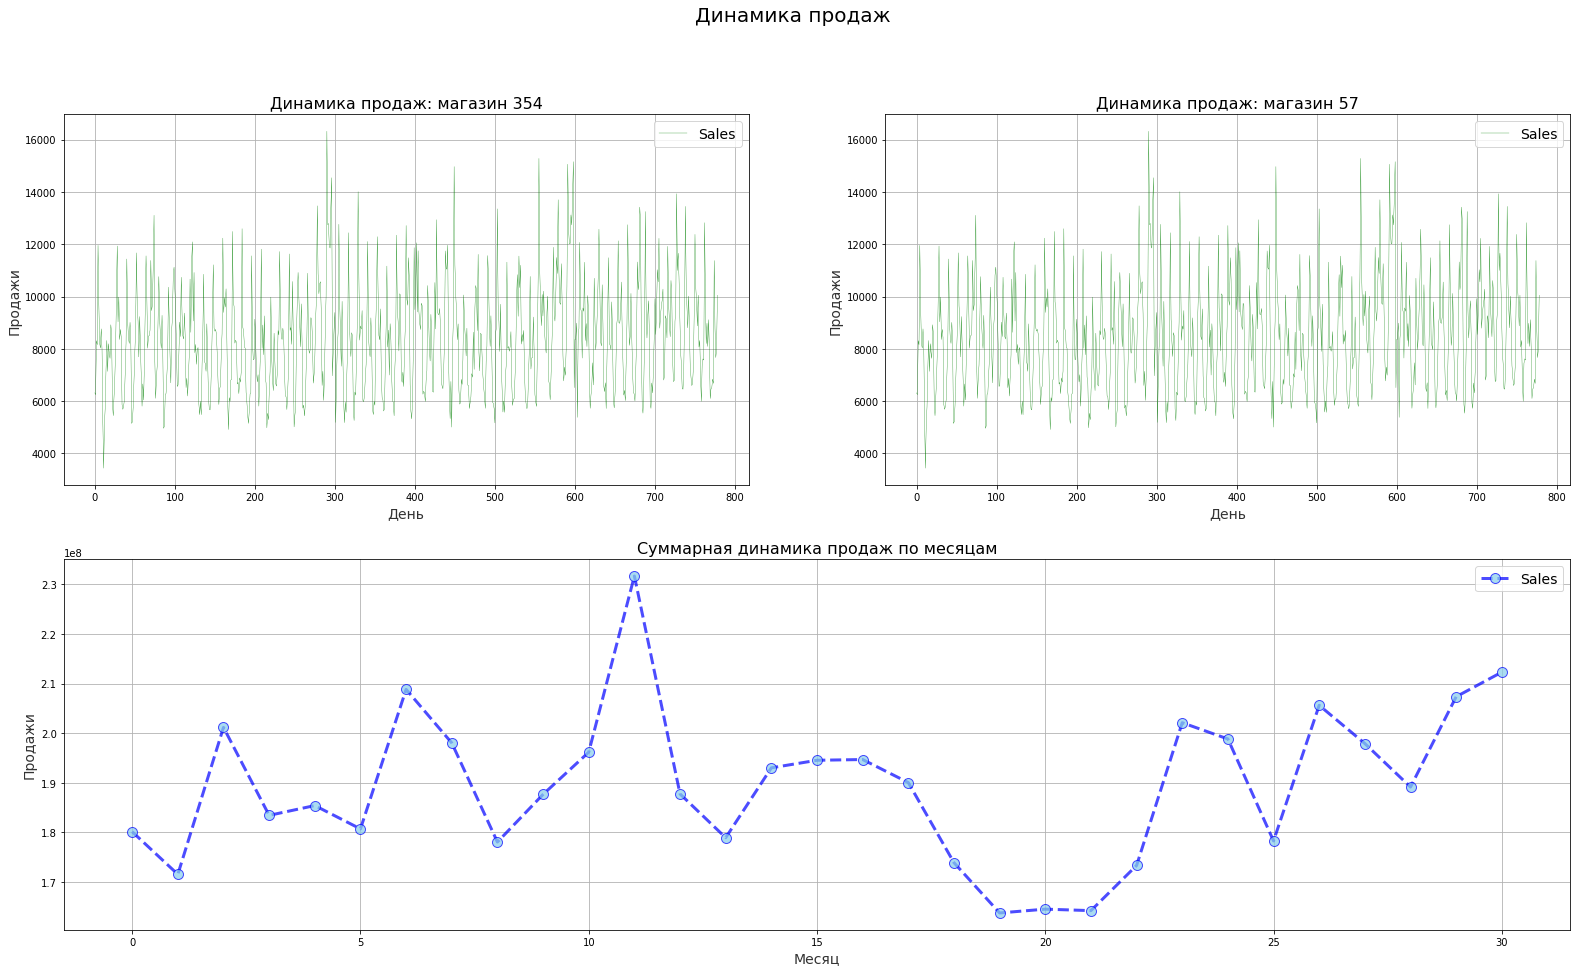

In [10]:
painter.plot_time_realations

По графикам видно отсутствие какого-либо тренда, продажи распределены достатчно ровно, как в магазинах так и в целом. Странно, что на декабрь 2103 года приходится значительный всплеск продаж, а на декабрь 2014 такого не наблютается

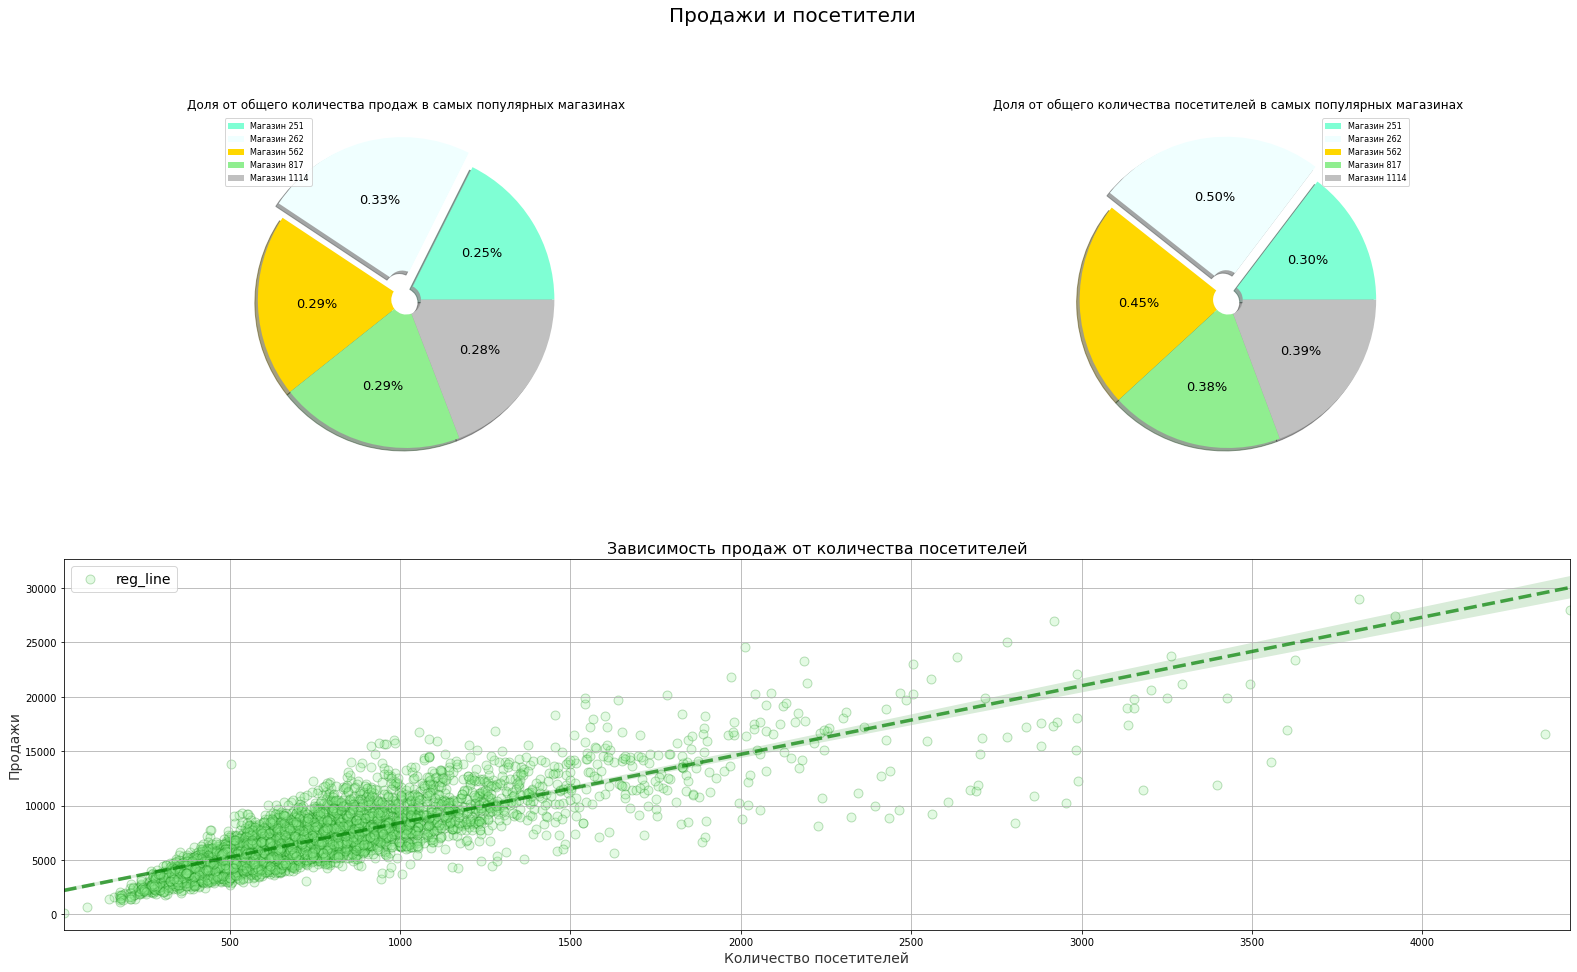

In [11]:
painter.plot_store_sales_customers(5000)

Здесь видим самые популярные магазины по количеству продаж. Видно, что доля продаж магазина от общего числа продаж не сильно отличается от доли количества посетителей магазина от общего числа посетителей. На самом деле два этих признака тестно связаны друг с другом, что выглядит очень логично. Отсюда значит, что нужно попытаться использовать данный признак для тестовой выборки (который там отсутствует)

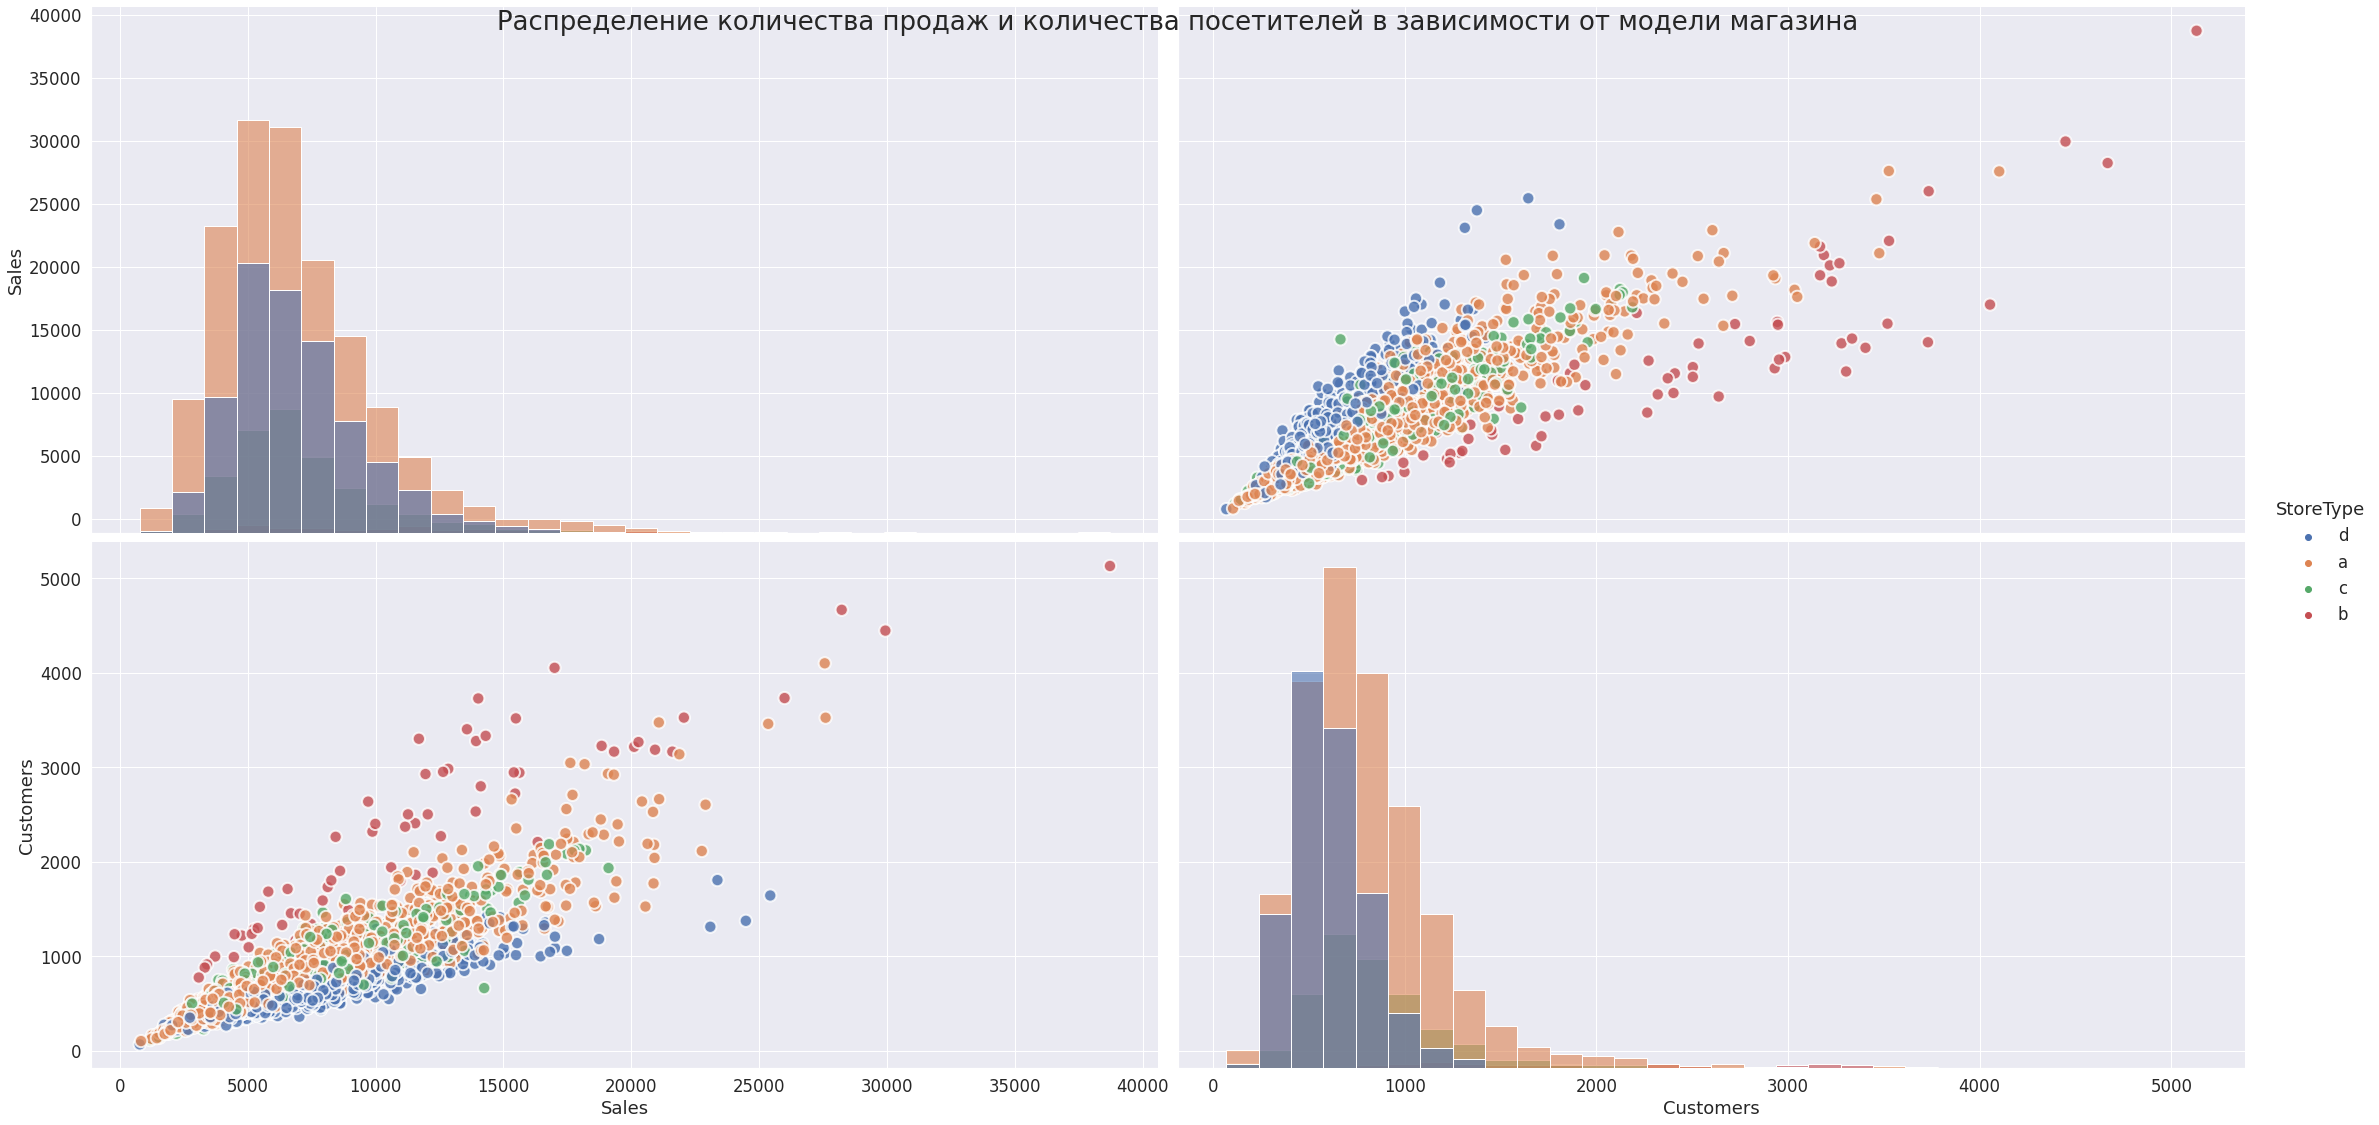

In [12]:
painter.plot_sales_customers_relations(feature='StoreType', alpha=0.6)

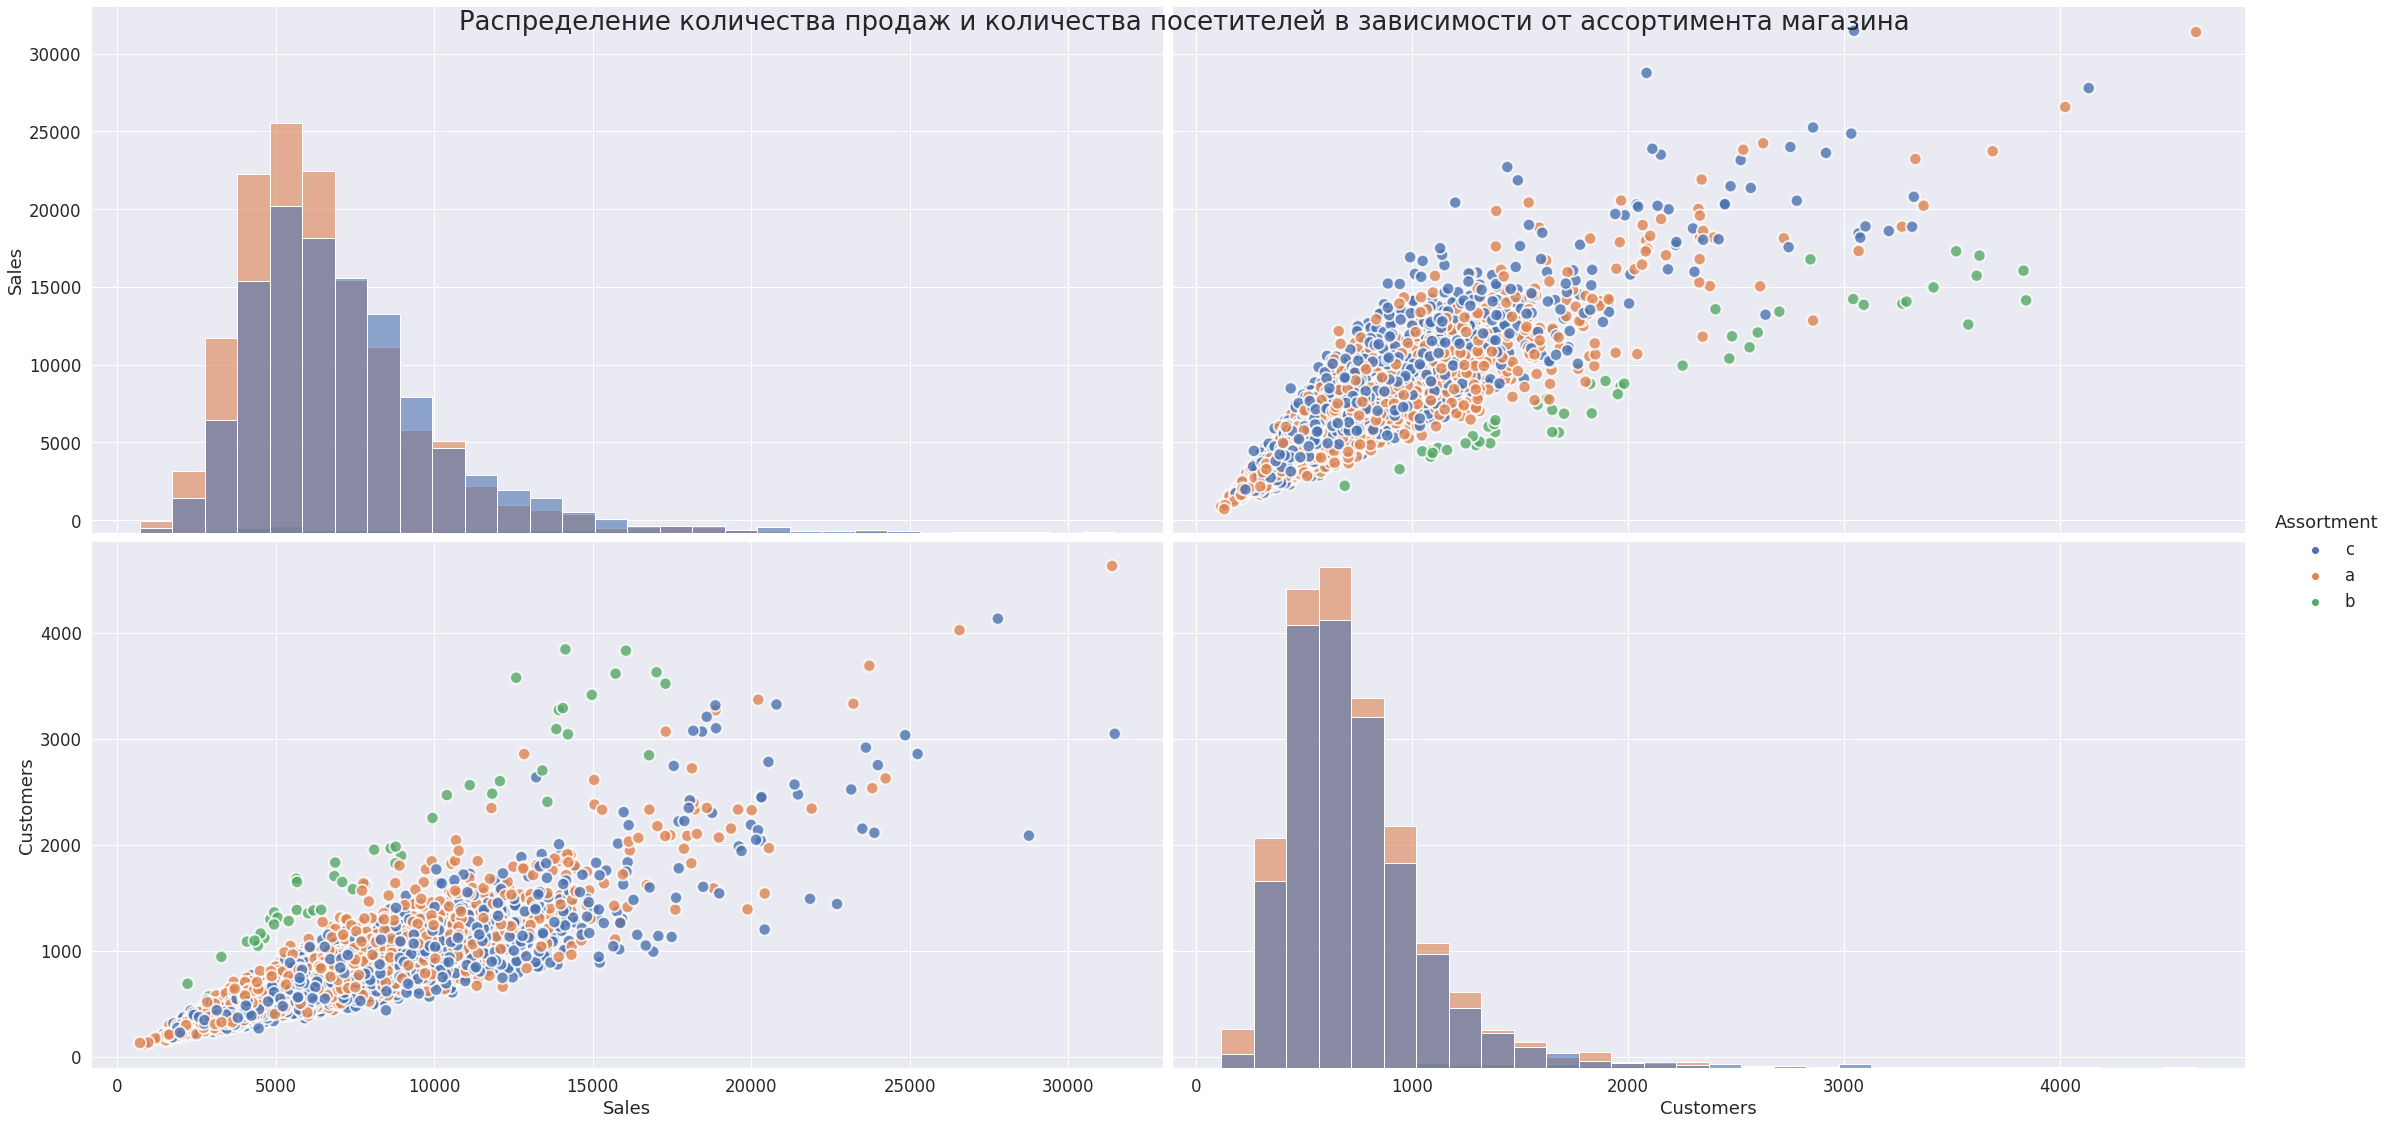

In [13]:
painter.plot_sales_customers_relations(feature='Assortment', alpha=0.6)

Из данных графиков отмечаем, что целевая переменная "Продажи", а также признак количества посетителей имеют распределение близкое к нормальному.
Видим, что магазины с моделями A и D суммарно имеют больше продаж, но в среднем самые высоки продажи у магазинов с моделью B

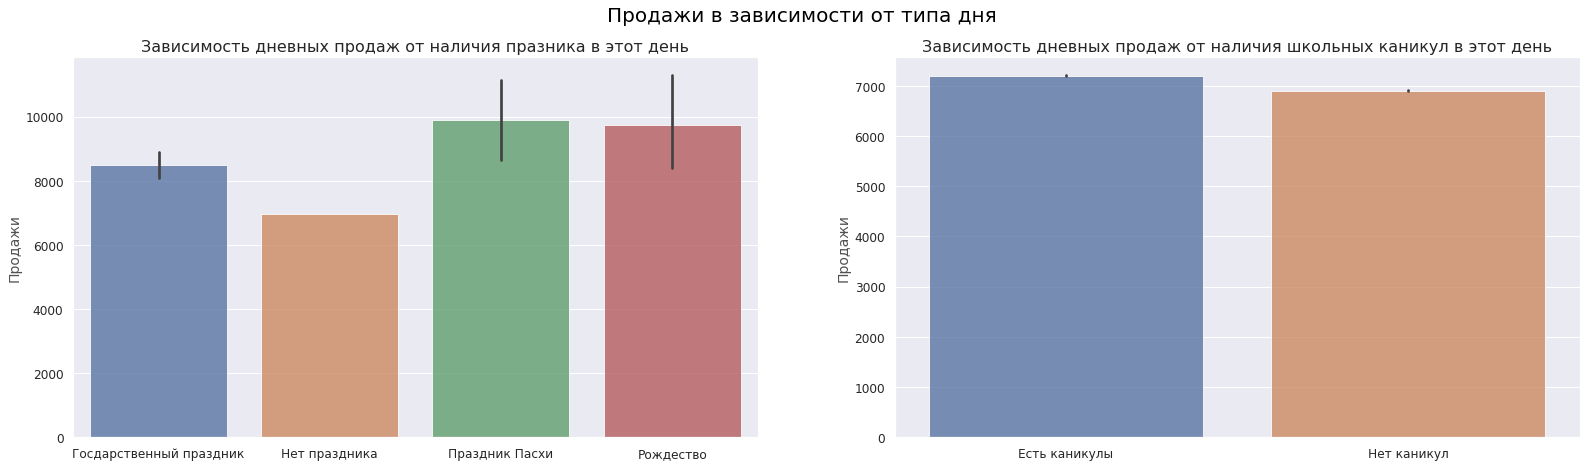

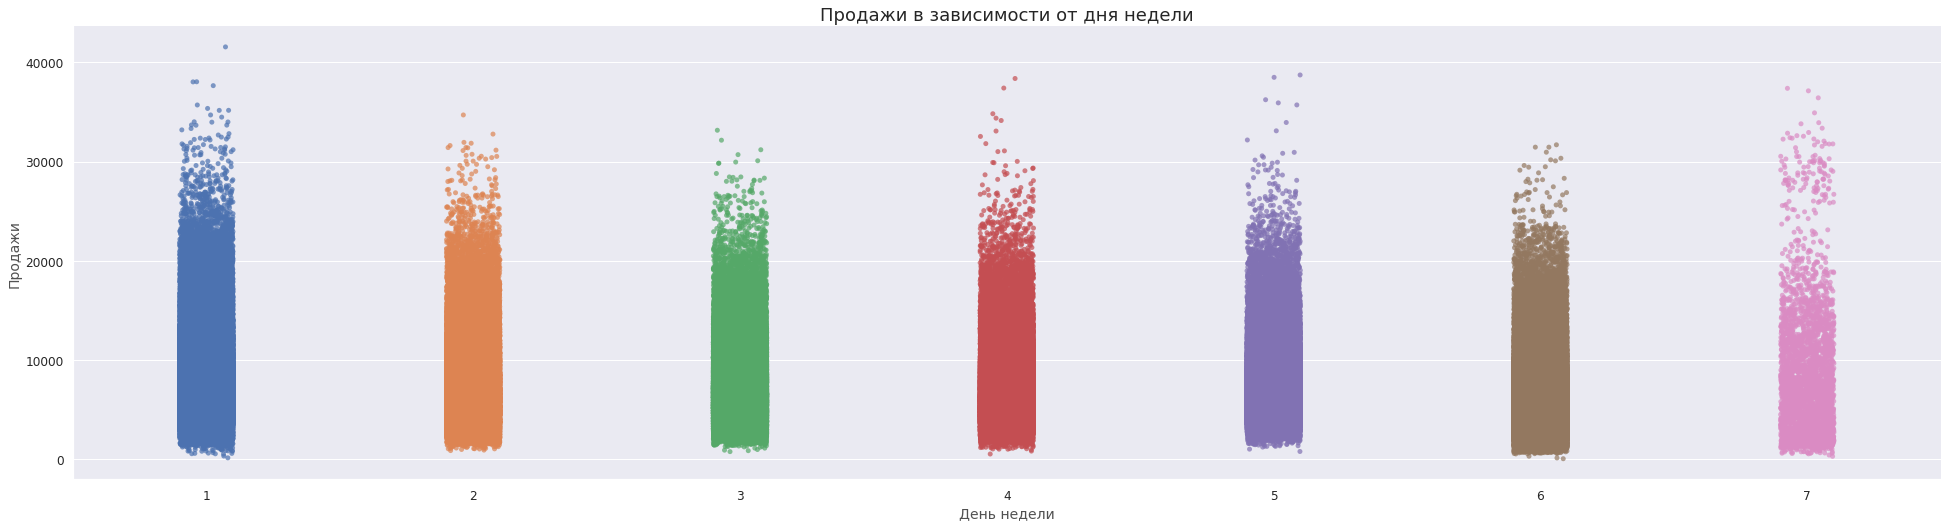

In [14]:
painter.plot_day_sales_relations

Здесь видим, что продажи зависят от наличия праздника, а также от наличия школьных каникул.
По дням недели продажи тоже распределенны не равномерно

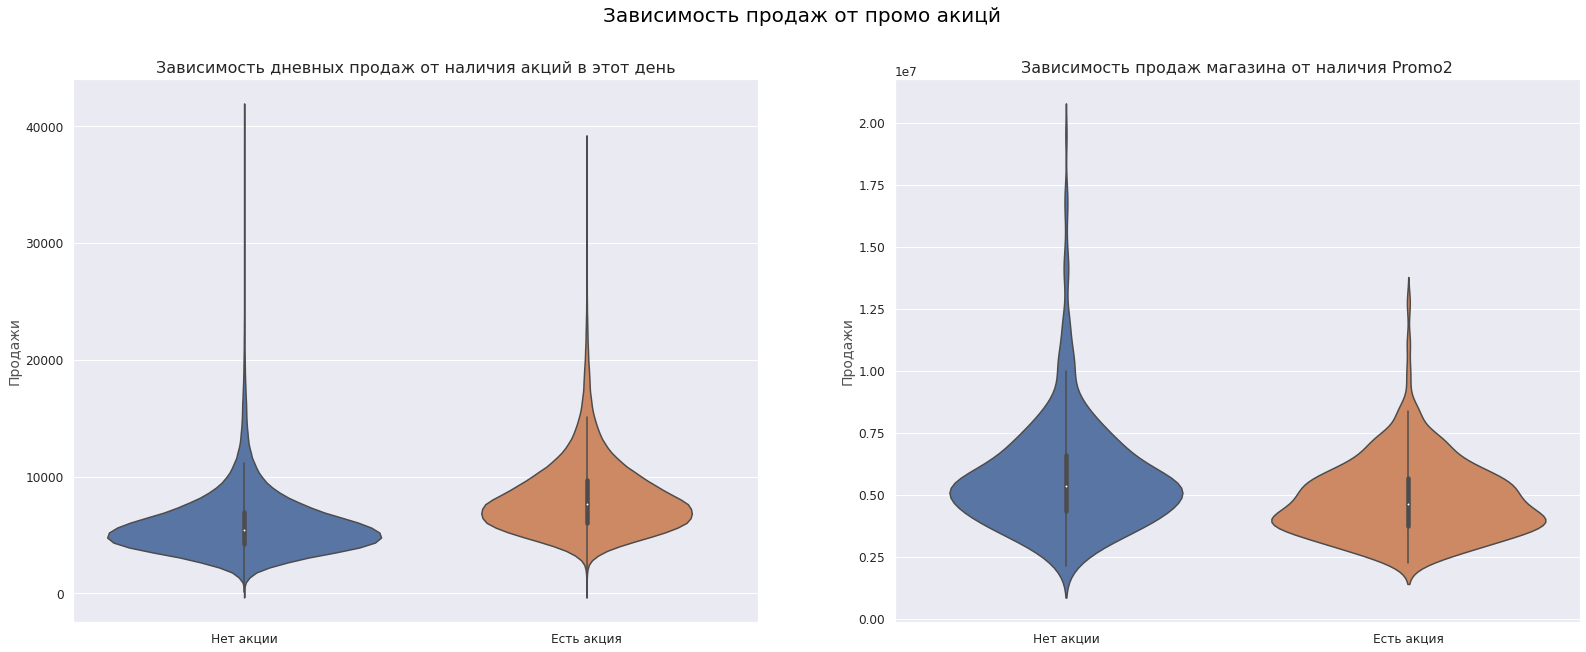

In [15]:
painter.plot_sales_promo_realation

Из данного рисунка видно, что в случае наличия у магазина акции Promo2 продажи ниже, чем в случае ее отсутствия, что странно, но наверняка это связанно с какими-то неизвестными причинами. Но отсюда можно предположить, что признак наличия Promo2 будет не самым полезным для построения модели.
В случае с признаком проведения каких-либо акций в конкретный день все логично: Если акция проводится - продаж больше

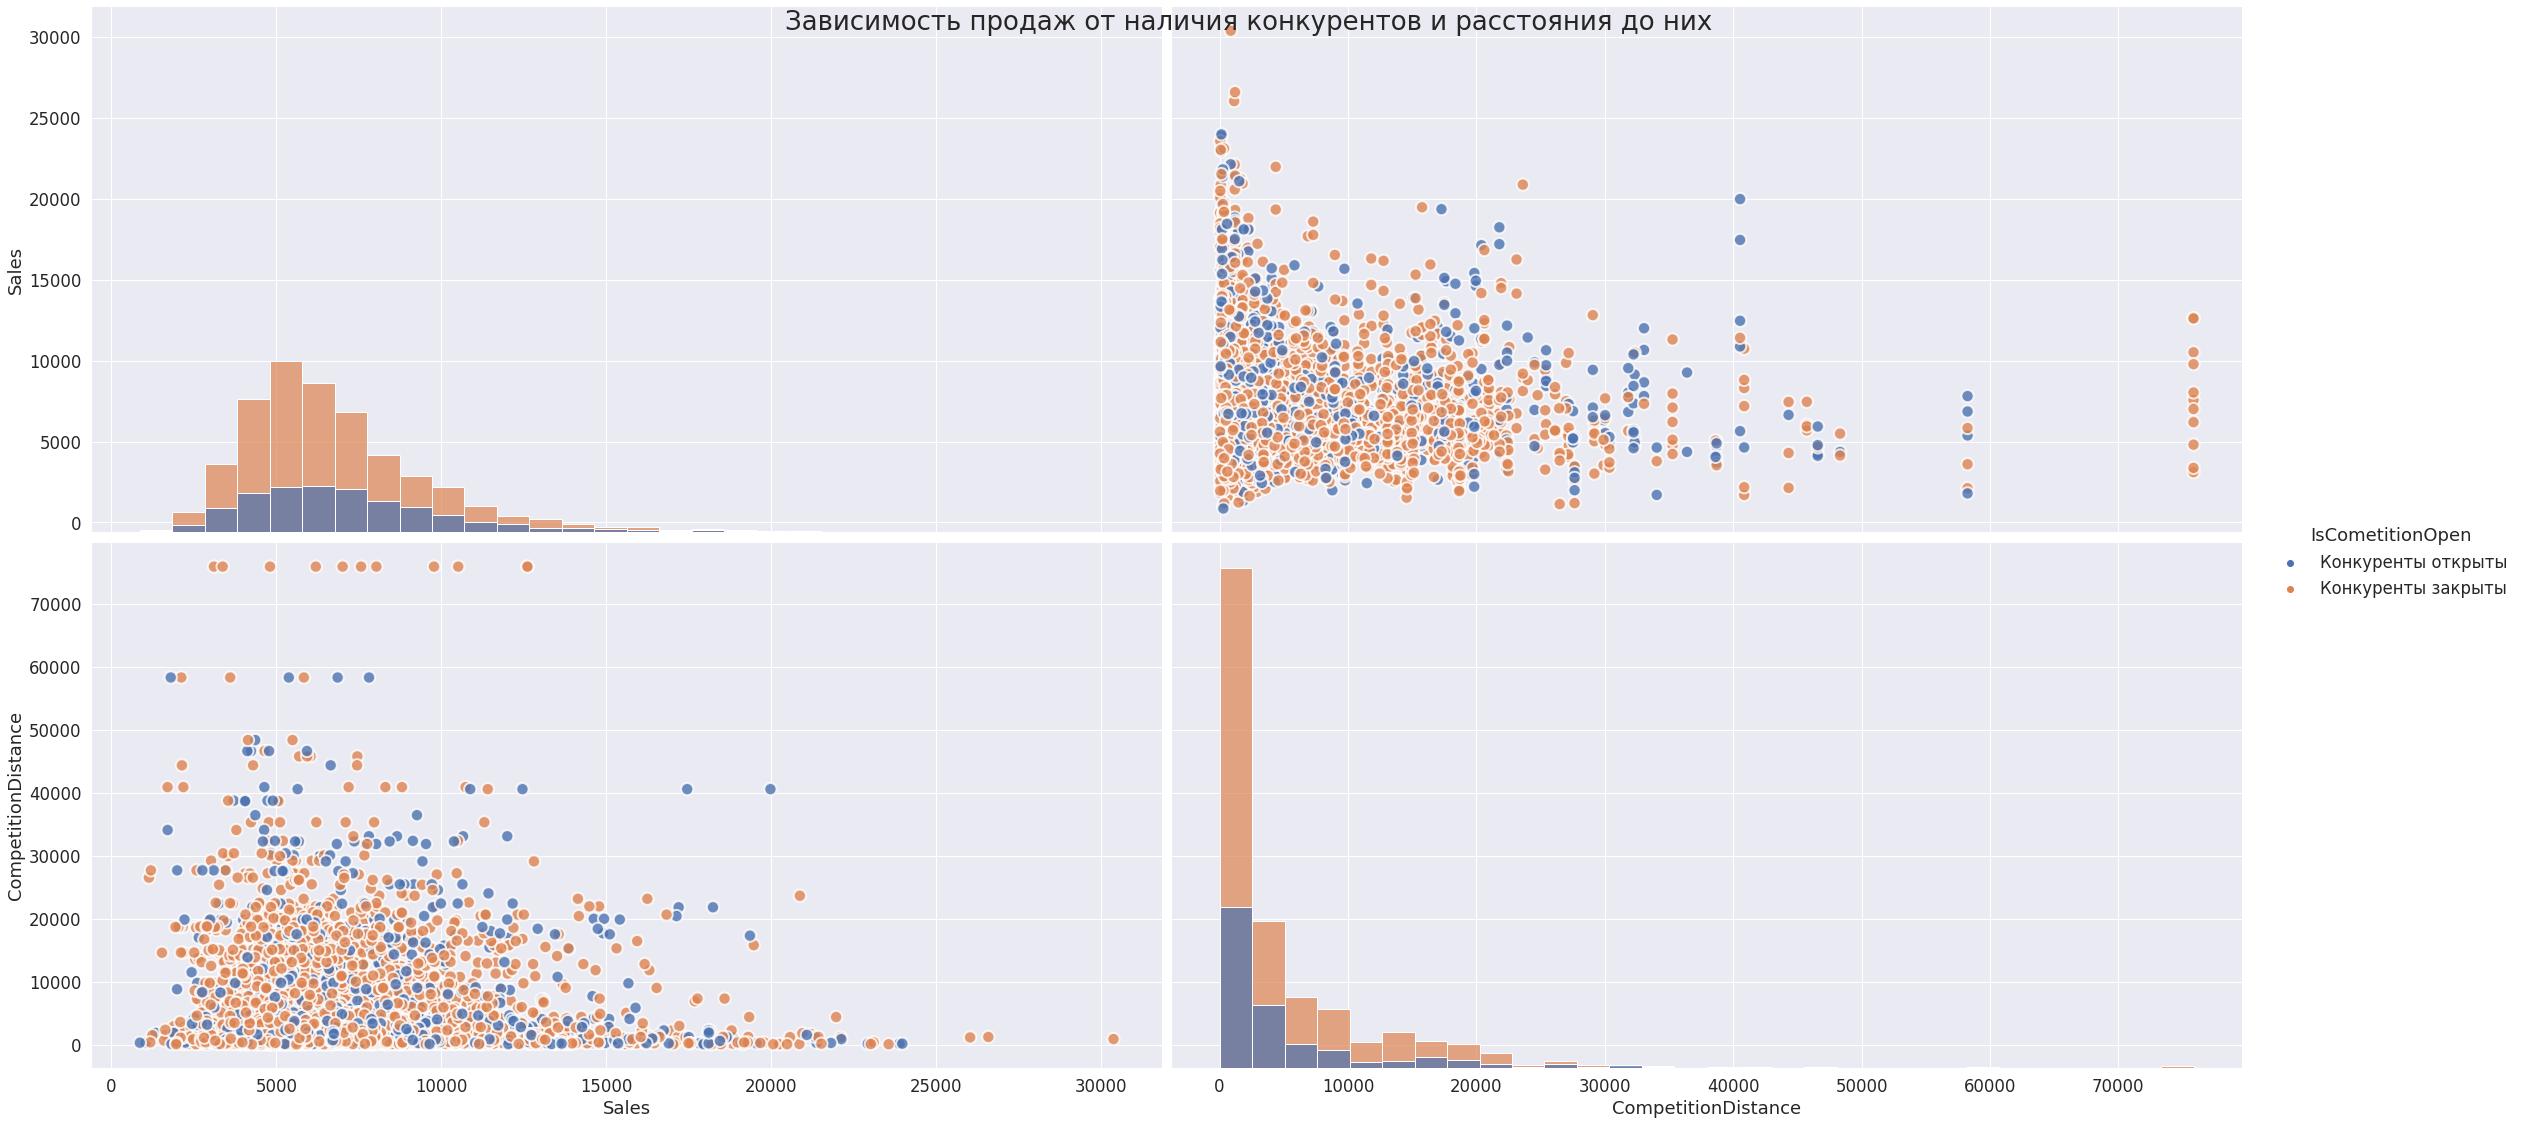

In [16]:
painter.plot_competitions_sales_relations(5000)

О зависимости от наличия конкурентов сказать трудно, если она есть, то не слишком высокая. А про зависимость от дистанции до ближайшего конкурента можно сказать, что она точно не линейна.

## 3. Обучение модели  и генерация признаков
- Генерация новых признаков
- Обучение и настройка моделей градиентного бустинга
- Оценка результатов

In [63]:
## Создадим класс для генерации новых признаков и дополнительные функции для него


class FeatureGenerator:
    """Класс для генерации новых признаков"""
    def __init__(self, dataframe):
        self.data = dataframe.copy()
    
    
    ## Здесь определяем признаки, связанные с наличием конкурентов и акцией 
    # Promo2 : is_promo2 - наличие акции к данному моменту времени
    ## IsPromoMonth - попадает ли конкретный день в месяц роведения данной акции,
    # IsCometitionOpen - наличие действующих конкурентов
    @property
    def promo2_competition_features(self):  
        
        self.data.Promo2SinceYear = self.data.Promo2SinceYear.apply(lambda x: int(x))
        self.data.Promo2SinceWeek = self.data.Promo2SinceWeek.apply(lambda x: int(x))
        self.data['week_number'] = self.data.Date.apply(lambda x: x.week)
            
        self.data['is_promo2'] = self.data[['year','week_number', 'Promo2SinceYear', 'Promo2SinceWeek']] \
        .apply(lambda x: check_promo_start(x[0], x[1], x[2], x[3]), axis=1)
        
        self.data['PromoInterval'] = self.data['PromoInterval'].apply(lambda x: change_promo_interval(x))
        self.data['IsPromoMonth'] = self.data[['PromoInterval', 'month']].apply(lambda x: 1 if x[1] in x[0] else 0, axis=1)
        self.data['IsCometitionOpen'] = self.data[['year','month', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']] \
        .apply(lambda x: check_competitions_open(x[0], x[1], x[2], x[3]), axis=1)
        
               
        self.data = self.data.drop(columns='week_number')
        
        pass
    
     ## Здесь определяем признаки, связанные с магазином, месяцем и днем недели.
     ## По два новых признака для каждого признака:
     ## среднии продажи и среднее количество посетителей.
     ## По признакам продаж возьмем значние логарифма   
    def mean_features(self, df_train, feature, marker='train'): 
        feature_customers_name = 'mean_' + feature +'_customers'
        feature_sales_name = 'mean_' + feature +'_sales'
        last_2_month = sorted(df_train.month_number.unique())[-2]
        df = df_train.copy()
        if marker == 'train':
            df = df_train[df_train.month_number < last_2_month]
        
        df_customers = df.groupby(feature)['Customers'].mean().reset_index()
        df_customers = df_customers.rename(columns={'Customers': feature_customers_name})
        df_customers[feature_customers_name] = df_customers[feature_customers_name].apply(lambda x: x)
        
        df_sales = df.groupby(feature)['Sales'].mean().reset_index()
        df_sales = df_sales.rename(columns={'Sales': feature_sales_name})
        df_sales[feature_sales_name] = df_sales[feature_sales_name].apply(lambda x: np.log(x))
        
        self.data = pd.merge(self.data, df_customers, on=feature, how='left')
        self.data = pd.merge(self.data, df_sales, on=feature, how='left')
        
    ## Попробуем отразить признаки связанные с историей продаж в магазине.
    ## Для этого для каждой даты в каждом магазине отобразим продажи 2 месяца назад,
    ## 3 месяца назад, 4 и так далее до 18-ого месяца. Также используем логарифм
    def time_features(self, time_dict, time_list,  fill='0'): 
        for i in tqdm(time_list):
            feature_name = 'shift_' + '{}'.format(i)
            self.data[feature_name] = self.data[['Store', 'Date']].apply(lambda x: comulate_tab_sales(x[0],
                                                                        x[1], time_dict, i) , axis=1)
            if fill == 'median':
                self.data[feature_name] = self.data[feature_name].fillna(self.data[feature_name].median())
            else:
                self.data[feature_name] = self.data[feature_name].fillna(0)
           
    
    @property
    def get_data(self):
        return self.data     
    
    

## Дальше описаны вспомогательные функции, которые помогают нам сгенерирвать вышеуказанные признаки
## Функции plot_corr_map и plot_feature_importances для отрисовки корреляционной матрицы
#  и важности признаков соответственно
## Также реализуем функцию search_parameters, которая позволит нам осуществлять подбор параметров по сетке.
## Тип кросс-валлидации возьмем TimeSeriesSplit, который будет учитывать порядок времени,
#  что является важным для нашей задачи

def check_promo_start(year, week, promo_year, promo_week):
    if (promo_year <= year) & (promo_year !=0):
        if (promo_week <= week) & (promo_week != 0):
            return 1
        else:
            return 0
    else:
        return 0

def comulate_tab_sales(store, date, time_dict, idx):
    new_date = date - dateutil.relativedelta.relativedelta(months=idx)
    try:
        result = np.log(time_dict[store][new_date])
    except KeyError:
        result = None
    return result


def get_time_dict(dataframe):
    time_dict = {store: {} for store in dataframe.Store.unique()}
    rows = dataframe.iterrows()
    for _, row in tqdm(rows):
        time_dict[row.Store].update({row.Date: row.Sales})
    
    return time_dict
    
    
def change_promo_interval(promo_interval):
    map_dict_1 = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
               'Jul': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

    try:
        promo_interval = promo_interval.split(',')
    except:
        promo_interval = []
    promo_interval = [map_dict_1[x] for x in promo_interval]
    return promo_interval

    

def check_competitions_open(year, month, comp_year, comp_month):
    if (comp_year <= year) & (comp_year !=0):
        if (comp_month <= month) & (comp_month != 0):
            return 1
        else:
            return 0
    else:
        return 0
    
    
def plot_corr_map(dataframe, time_list):
    df = dataframe.copy()
    plt.figure(figsize=(30,17))
    columns = ['shift_{}'.format(i) for i in time_list] + ['Sales']
    sns.heatmap(df[columns].corr(), annot=True, cmap=sns.color_palette("Blues", as_cmap=True));
    plt.title('Корреляционная матрица новых признаков, характеризцющих продажи', fontsize=20);
    
    
def plot_feature_importances_lgb(X_train, y_train, n_estimators):
    model = LGBMRegressor(n_estimators=n_estimators, num_leaves=512, learning_rate=0.04)
    model.fit(X_train, y_train)
    df = pd.DataFrame({'features': X_train.columns, 'importances': model.feature_importances_})
    df = df.sort_values(by='importances', ascending=False).reset_index(drop=True)
    sns.set(font_scale=1.5)
    catplot = sns.catplot(data=df, x='importances', y='features', kind='bar',
                          height=17, aspect=27/17, legend_out=True)
    plt.title('Важность признаков', fontsize=23)
    plt.xlabel('Степень важности признака', fontsize=19, alpha=0.8)
    plt.ylabel('')
    sns.reset_orig()
        
        
        
def search_parameters(model, parameters, X, y, cv):
    parameters_size = [len(v) for v in parameters.values()]
    size = 1
    for s in parameters_size:
        size = size * s
    size = int(size/2)
    ts = TimeSeriesSplit(n_splits=cv)
    my_cv = ts.split(X)
    gsv = GridSearchCV(estimator=model, param_grid=parameters, cv=my_cv, verbose=size)
    gsv.fit(X, y)
    return gsv

In [26]:
%%time
## Выполним генерацию новых признаков
## Это занимает некотрое время, так как мы генерируем 26 новых признаков

time_dict = get_time_dict(df)
time_list = [i for i in range(2, 20)]

generator = FeatureGenerator(df)
generator.promo2_competition_features
generator.mean_features(df, feature='Store', marker='train')
generator.time_features(time_dict, fill='0', time_list=time_list)
generator.mean_features(df, feature='DayOfWeek', marker='train')
generator.mean_features(df, feature='month', marker='train')

new_df = generator.get_data
new_df.head()

844338it [01:26, 9789.68it/s] 
100%|██████████| 18/18 [10:57<00:00, 36.51s/it]


CPU times: user 12min 55s, sys: 6.93 s, total: 13min 1s
Wall time: 13min 2s


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,mean_DayOfWeek_customers,mean_DayOfWeek_sales,mean_month_customers,mean_month_sales
0,1097,2,2013-01-01,5961,1405,1,0,a,1,b,...,0.0,0.0,0.0,0.0,0.0,0.0,770.100964,8.861633,722.581699,8.789401
1,85,2,2013-01-01,4220,619,1,0,a,1,b,...,0.0,0.0,0.0,0.0,0.0,0.0,770.100964,8.861633,722.581699,8.789401
2,259,2,2013-01-01,6851,1444,1,0,a,1,b,...,0.0,0.0,0.0,0.0,0.0,0.0,770.100964,8.861633,722.581699,8.789401
3,262,2,2013-01-01,17267,2875,1,0,a,1,b,...,0.0,0.0,0.0,0.0,0.0,0.0,770.100964,8.861633,722.581699,8.789401
4,274,2,2013-01-01,3102,729,1,0,a,1,b,...,0.0,0.0,0.0,0.0,0.0,0.0,770.100964,8.861633,722.581699,8.789401


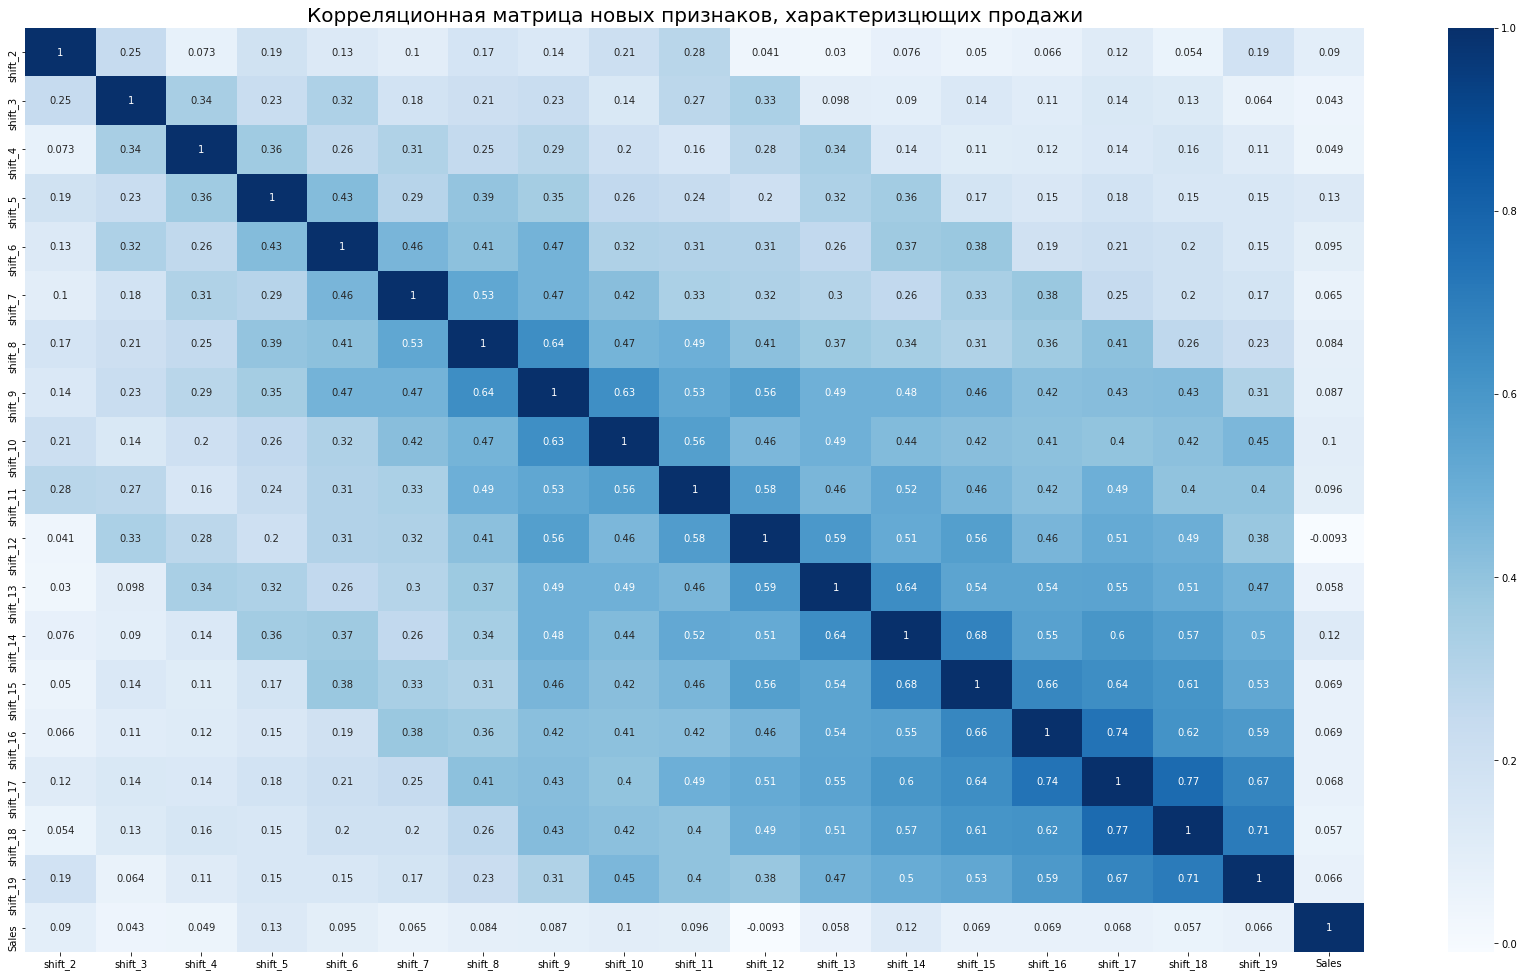

In [30]:
## Изобразим корреляционную матрицу новых признаков отступа
plot_corr_map(new_df, time_list)

Замечаем, что корреляция между признаками отступов тем больше, чем ближе они к друг другу. Также чем больше отступы тем выше корреляция, но это обусловленно тем, что для больших отступов у нас не всегда достаточно информации в данных, соответственно у этих признаков много нулей. Собственно поэтому мы ограничиваемся максимальным отступом в 19 месяцев. 
Также видим, что целевая переменная линейно не зависист, от данных признаков

In [ ]:
%%time
## Теперь будем выбирать и настраивать модель используя валлидационную выборку

cat_columns = ['StateHoliday', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceYear', 
               'StoreType', 'Assortment']
drop_columns = ['Date', 'Customers', 'PromoInterval', 'year', 'Open', 'month_number']

X_train, X_test, y_train, y_test = split_data(new_df)
X_train, X_test = encode_data(X_train, X_test, cat_columns)
X_train = drop(X_train, drop_columns)
X_test = drop(X_test, drop_columns)

"""params = {'num_leaves': 512, 'objective': 'regression', 'learning_rate': 0.03,
        'metric': 'rmse', 'first_metric_only': True}

params = {'objective': 'reg:linear', 'max_depth': 9, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8}"""
params = {'max_depth': 9, 'iterations': 35000, 'learning_rate': 0.045}

num_rounds = 35000
early_stoping = 2000
boost_type = 'ctb'
boost = ctb
bst = train_boosting(boost, params, X_train, y_train, X_test=X_test, y_test=y_test,
                     marker='val', num_rounds=num_rounds, early_stoping=early_stoping,
                     verbose=50, feval=rmspe_boost, boost_type=boost_type)
preds = predict_boosting(bst, X_train, X_test, y_train, y_test, boost_type='ctb')

Здесь опущен момент подбора параметров, но в результате такого подбора стабильнее всего себя проявила модель CatBoost. Дальше будем использовать ее

In [28]:
%%time
## Также сгенерируем новые признаки для тестовой выборки

df_test = get_data(test_path=test_path, marker='test')
test = merge_data(df_test, df_store)
test = preprocessed_data(test, marker='test')

generator = FeatureGenerator(test)
generator.promo2_competition_features
generator.mean_features(df, feature='Store', marker='test')
generator.time_features(time_dict, fill='0', time_list=time_list)
generator.mean_features(df, feature='DayOfWeek', marker='test')
generator.mean_features(df, feature='month', marker='test')
new_test = generator.get_data
new_test.head()

100%|██████████| 18/18 [00:31<00:00,  1.74s/it]


CPU times: user 33.7 s, sys: 87.1 ms, total: 33.8 s
Wall time: 33.8 s


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,mean_DayOfWeek_customers,mean_DayOfWeek_sales,mean_month_customers,mean_month_sales
0,41088,1115,6,2015-08-01,1.0,0,0,1,d,c,...,0.0,0.0,8.896177,8.873328,8.921324,0.0,660.205023,8.678476,750.412288,8.802256
1,40523,378,6,2015-08-01,1.0,0,0,0,a,c,...,0.0,0.0,9.056490,8.784468,8.735043,0.0,660.205023,8.678476,750.412288,8.802256
2,40522,377,6,2015-08-01,1.0,0,0,0,a,c,...,0.0,0.0,9.249657,8.891099,8.800265,0.0,660.205023,8.678476,750.412288,8.802256
3,40521,373,6,2015-08-01,1.0,0,0,0,d,c,...,0.0,0.0,8.242493,8.574329,8.574518,0.0,660.205023,8.678476,750.412288,8.802256
4,40520,372,6,2015-08-01,1.0,0,0,0,d,c,...,0.0,0.0,9.219003,9.035034,9.013595,0.0,660.205023,8.678476,750.412288,8.802256


In [32]:
%%time
## Обучим выбранную модель на всей выборке и сделаем предсказания для теста.
## Тест предварительно делим на дни, когда магазин закрыт и открыт.
## Продажи в те дни, когда магазин закрыт заполняем нулями


new_test_closed, new_test_open = test_filter(new_test)

cat_columns = ['StateHoliday', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceYear',
               'StoreType', 'Assortment']
drop_columns_trian =  ['Date', 'Customers', 'PromoInterval', 'year', 'Open', 'month_number']
drop_columns_test =  ['Date', 'Id', 'PromoInterval', 'year', 'Open', 'month_number']


X_train, y_train = split_data(new_df, marker='test')
X_test = new_test_open
X_train, X_test = encode_data(X_train, X_test, cat_columns)
X_train = drop(X_train, drop_columns_trian)
X_test = drop(X_test, drop_columns_test)


cat_params = {'max_depth': 9, 'iterations': 35000, 'learning_rate': 0.045}

if boost_type == 'lgb':
    bst = train_boosting(boost, params, X_train, y_train, X_test=X_test,
                     marker='test', num_rounds=num_rounds, early_stoping=early_stoping,
                     verbose=2000, feval=rmspe_boost, boost_type=boost_type)
elif boost_type == 'xgb':
    bst = train_boosting(boost, params, X_train, y_train, X_test=X_test,
                     marker='test', num_rounds=num_rounds, early_stoping=early_stoping,
                     verbose=2000, feval=rmspe_boost, boost_type=boost_type)
elif boost_type == 'ctb':
    bst = train_boosting(boost, cat_params, X_train, y_train, X_test=X_test,
                     marker='test', num_rounds=num_rounds, early_stoping=early_stoping,
                     verbose=2000, feval=rmspe_boost, boost_type=boost_type)
    


pred = predict_boosting(bst, X_train, X_test, y_train, boost_type=boost_type)
new_test_open['Sales'] = pred

0:	learn: 2996.9756509	test: 2977.5039521	best: 2977.5039521 (0)	total: 149ms	remaining: 1h 27m 3s
2000:	learn: 774.2042295	test: 712.8260851	best: 712.8260851 (2000)	total: 5m 18s	remaining: 1h 27m 39s
4000:	learn: 698.5259582	test: 621.5032147	best: 621.5032147 (4000)	total: 10m 36s	remaining: 1h 22m 13s
6000:	learn: 654.5546332	test: 571.3424237	best: 571.3424237 (6000)	total: 15m 49s	remaining: 1h 16m 29s
8000:	learn: 622.5358994	test: 534.9028391	best: 534.9028391 (8000)	total: 21m 2s	remaining: 1h 11m 1s
10000:	learn: 597.6574186	test: 506.2816779	best: 506.2816779 (10000)	total: 26m 18s	remaining: 1h 5m 45s
12000:	learn: 576.8801642	test: 481.6739114	best: 481.6739114 (12000)	total: 31m 37s	remaining: 1h 37s
14000:	learn: 558.6949593	test: 460.0187156	best: 460.0187156 (14000)	total: 37m	remaining: 55m 30s
16000:	learn: 542.9039629	test: 441.0340505	best: 441.0340505 (16000)	total: 42m 22s	remaining: 50m 18s
18000:	learn: 528.6471929	test: 424.2073465	best: 424.2073465 (18000)	t

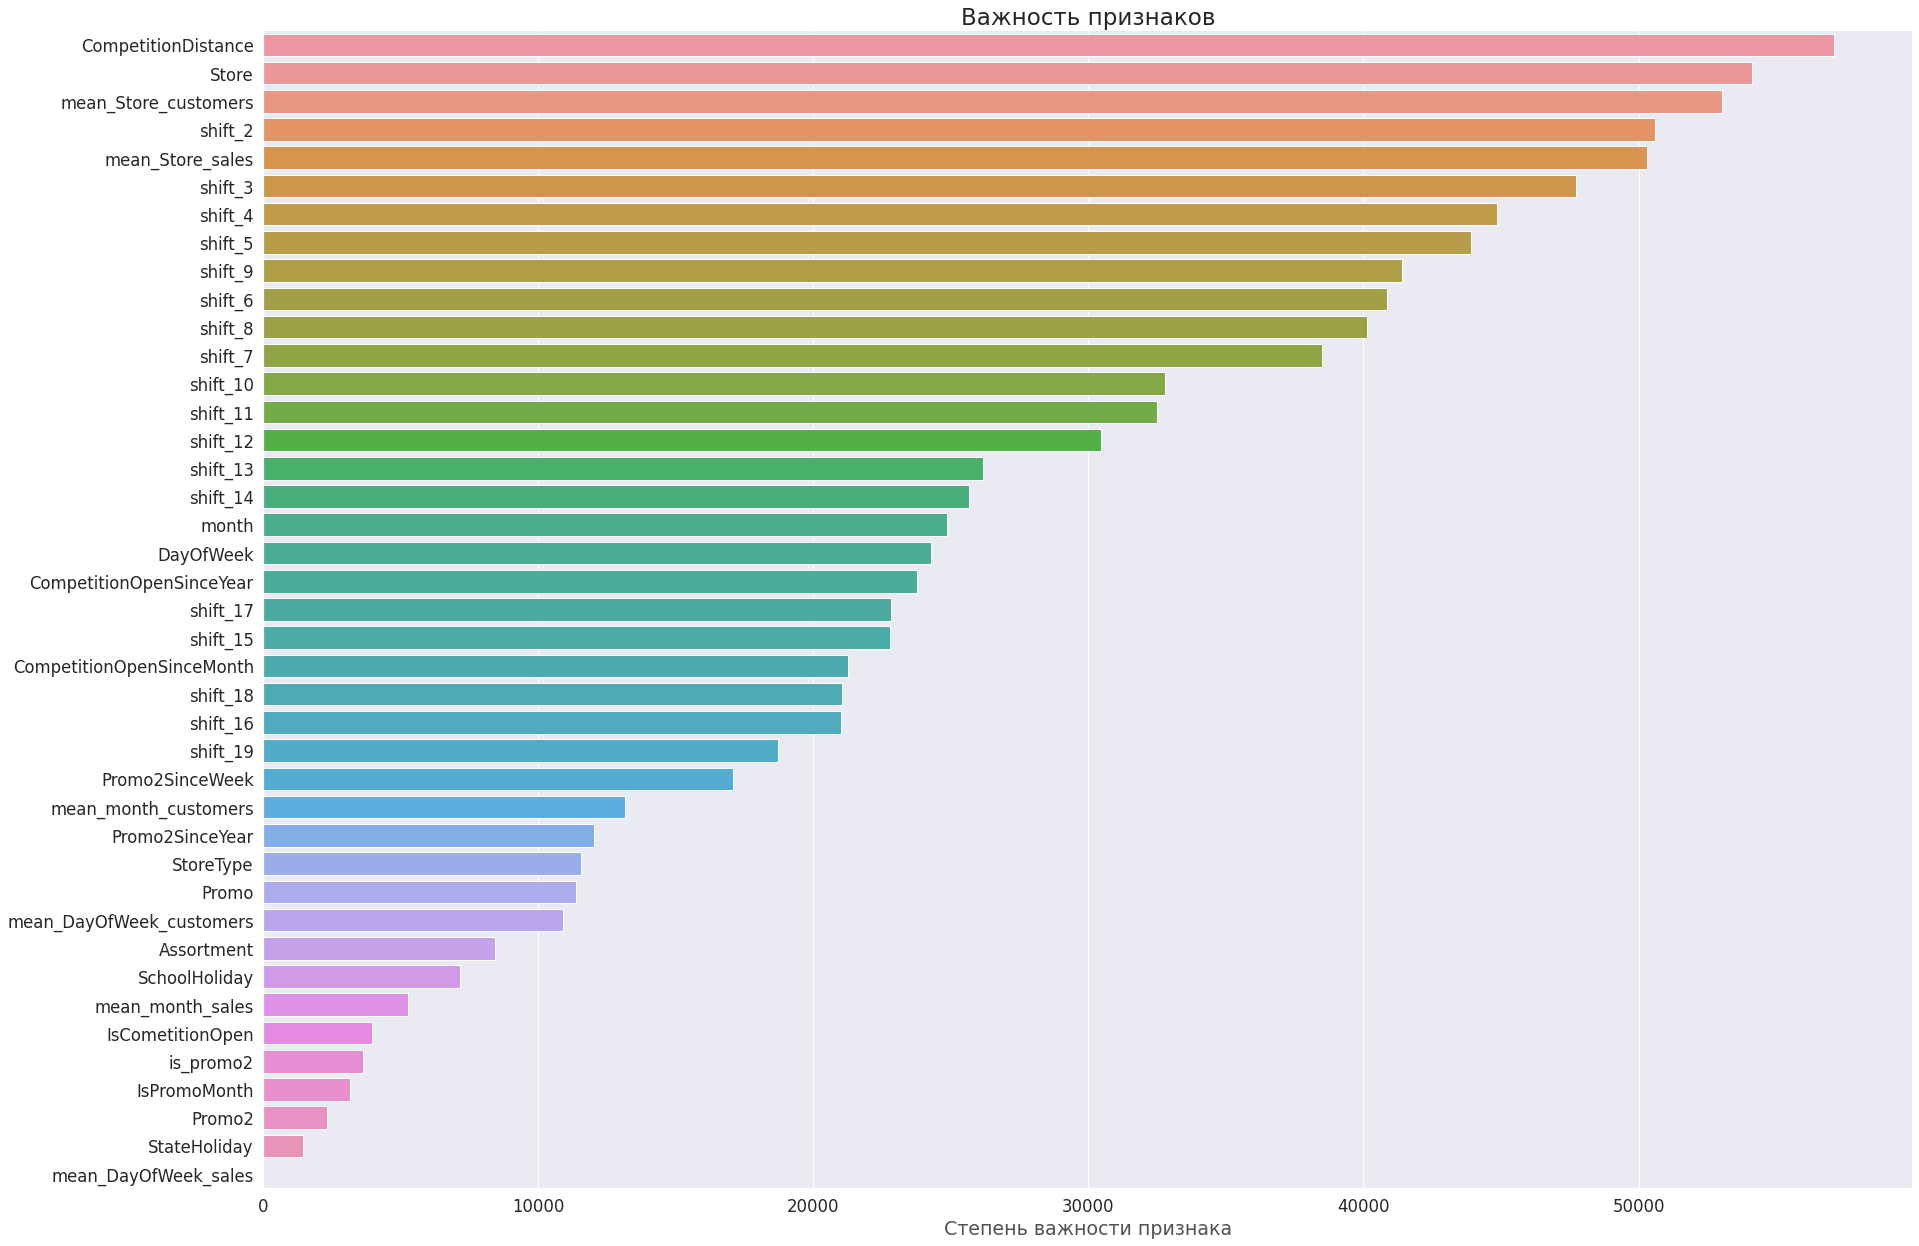

In [64]:
## Изобразим важность признаков используя моедель LGBM на 2000 итерациях, так как она работает быстрее других
plot_feature_importances_lgb(X_train, y_train, 2000)

Видим, что очень важным оказывается признак расстояния до конкурентов, а также новые сгенерированные признаки средних продаж, среднего количества посетителей и признаки отступа. Менее значимыми признаками оказываются признаки связанные с участием магазина в акции Promo2, как мы и предполагали ранее

In [ ]:
## Сохраним результат и отправим решение
result = pd.concat([new_test_open, new_test_closed])[['Id', 'Sales']].sort_values(by='Id') \
                                                                     .reset_index(drop=True)
result.to_csv('submission.csv', index=False)
result.head()

#### Итого: Лучший результат - RMSPE 0.128  был достигнут используя:
1. Новые сгенерированные признаки: Среднии продажи и количество посетителей по дню недели, месяцу и по магазину, а также признаки, характеризующие историю продаж магазина - отступы во времени с различным интервалом
2. Подбор параметров используя TimeSeriesSplit и валидационную выборку похожую на тестовую(2 последних месяца)
3. Модель CatBoostRegressor(max_depth=9, iterations=35000, learning_rate=0.045)